# Tarea 1, parte 2

De Sirianni et al. (2015), podemos transformar de los filtros F555W y F814 utilizando la siguiente función.


In [1]:
def trans_to_UVBRI(sf555, sf814, f555_zp, f814_zp, f555_av, f814_av):
    # Primero le quitamos el zero point
    sf555 -= f555_zp
    sf814 -= f814_zp
    
    # Ahora el reddening
    sf555 += f555_av
    sf814 += f814_av   
    
    # Coeficientes para transformar de f555 a V.
    c0v = [25.250, 25.275]
    c1v = [-0.09, -0.124]
    c2v = [0.034, 0.018]
    
    # Coeficientes para transformar de f814 a I.
    c0i = [24.837, 24.838]
    c1i = [0.060, 0.001]
    c2i = [-0.099, 0.013]
    
    # Para una primera aproximación
    mag_v = sf555
    mag_i = sf814
    
    for _ in range(0, 10):
        tcol = mag_v - mag_i
        # Tomamos los índices según el rango de TCOl.
        idv = 0 if tcol < 0.6 else 1
        idi = 0 if tcol < 0.1 else 1
        
        mag_v = sf555 + c0v[idv] + c1v[idv]*tcol + c2v[idv]*(tcol)**2
        mag_i = sf814 + c0i[idi] + c1i[idi]*tcol + c2i[idi]*(tcol)**2

    # Agregamos el reddening:
    mag_v -= 0.101
    mag_i -= 0.056
    return (mag_v, mag_i)

Aplicamos esta transformación a los datos de la parte 1.

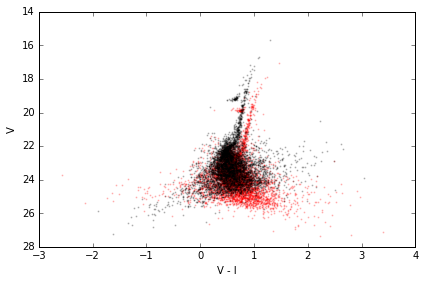

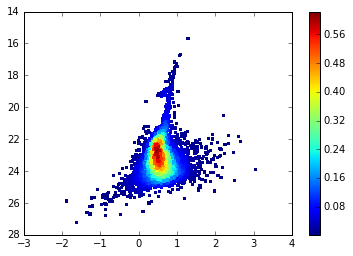

In [2]:
from scipy.stats import gaussian_kde
import tarea1_parte1
import numpy as np


Tarea1 = tarea1_parte1.Tarea1Parte1()

mag = zip(Tarea1.f555_mag, Tarea1.f814_mag)
params = (Tarea1.f555_zp, Tarea1.f814_zp, Tarea1.f555_av, Tarea1.f555_av)
mag = list(map(lambda x: trans_to_UVBRI(x[0], x[1], *params), mag))

%matplotlib inline
import matplotlib.pyplot as plt

axis_x = list(map(lambda x: x[0]-x[1], mag))
_, axis_y = zip(*mag)

plt.scatter(np.array(Tarea1.f555_mag) - np.array(Tarea1.f814_mag), Tarea1.f555_mag, marker='o', color='Red', s=1, alpha=0.2)
plt.scatter(axis_x, axis_y, marker='o', c='Black', s=1, alpha=0.2)
plt.xlabel('V - I')
plt.ylabel('V')
plt.tight_layout()
axes = plt.gca()
axes.invert_yaxis()
#axes.set_xlim([0.7, 0.9])
#axes.set_ylim([27, 16])
plt.show()

x = axis_x
y = axis_y

# Código adaptado del amigo de stackoverflow: 
# http://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
axes.invert_yaxis()

plt.show()

Buscamos una isócrona para NGC 121, que tiene una edad de [10.5 Gyr](http://iopscience.iop.org/article/10.1088/0004-6256/135/4/1106/pdf). También necesitamos agregar la distancia y el reddening. Además vamos agregar la [metalicidad](https://arxiv.org/pdf/1002.4301v2.pdf): -1.5 dex.

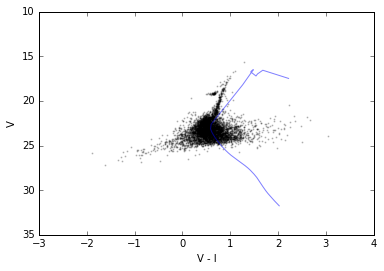

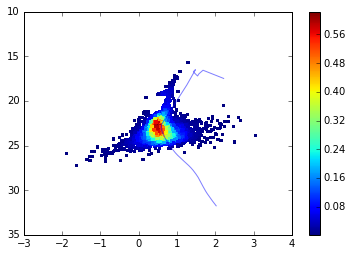

In [3]:
from isochrones.dartmouth import Dartmouth_Isochrone
import numpy as np

# Parámetros
age = np.log10(11.8*(10**9))
distance = 60000
fe_h = -1.5
a_v = [0.101, 0.056]

isochrone = Dartmouth_Isochrone(['V','I'])

model = isochrone.isochrone(age, fe_h, distance=distance, AV=a_v[0])

model_y = model.V_mag
model_x = model.V_mag - model.I_mag


plt.plot(model_x, model_y, alpha=0.5)

axes = plt.gca()
axes.invert_yaxis()
plt.xlabel('V - I')
plt.ylabel('V')

plt.scatter(x, y, marker='o', c='Black', s=1, alpha=0.2)
plt.show()


xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
axes.invert_yaxis()
plt.plot(model_x, model_y, alpha=0.5)
plt.show()


Necesitamos conocer la "ridge line" del CMD. Como las estrellas post-secuencia principal son menos, utilizaremos dos bins.

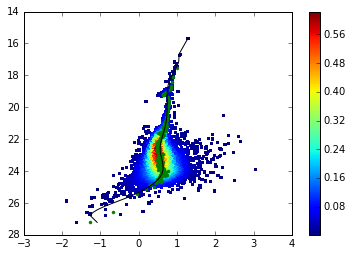

In [4]:
from scipy.interpolate import splrep, splev

bin_ms = 40
bin_pms = 8

x_fits = []
y_fits = []

# Ordenamos las estrellas para poder dividir en bins.
xy = list(zip(y, x))
xy.sort()
y, x = zip(*xy)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
temp_x = list(x)
temp_y = list(y)


for bin_id in [bin_pms, bin_ms]:
    for num in range(0, len(temp_x), bin_id):
        if temp_y[num] < 21.8 or bin_id == bin_ms:
            x_fits.append(np.median(temp_x[num: num+bin_id]))
            y_max = np.max(temp_y[num: num+bin_id])
            y_min = np.max(temp_y[num: num+bin_id])
            y_fits.append((y_max+y_min)/2)
        else:
            del temp_x[0: del_ind]
            del temp_y[0: del_ind]
            break
        del_ind = num

# spline de los datos originales
nknots = 7
knots = np.arange(y[1], y[len(y)-1],(y[len(y)-1]-y[1])/np.double(nknots))
tck = splrep(y, x, t=knots)
fit = splev(y, tck)

fig, ax = plt.subplots()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
im = ax.scatter(x, y, c=z, s=10, marker='s', edgecolor='')
axes = plt.gca()
fig.colorbar(im)
axes.invert_yaxis()

plt.plot(x_fits, y_fits, 'g.')
plt.plot(fit, y, '-', color='black')
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.show()